In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from open3d.pipelines.registration import registration_icp, TransformationEstimationPointToPoint
import copy


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


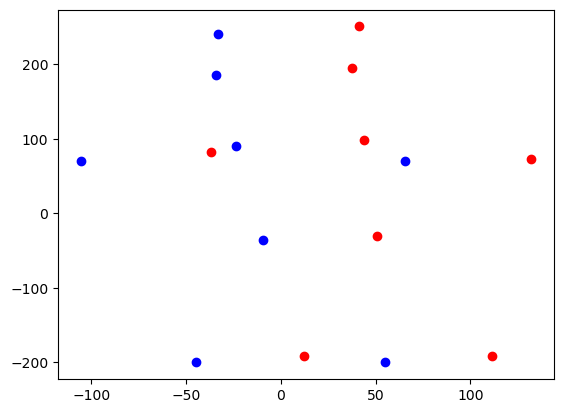

In [2]:
path = r'D:\StageE23\Data\Ete_2023\Participant19'

json_corr = open(os.path.join(path, r'Corrected\Prise01\Positions\positions_xyzr.json'))
pos_corr = json.load(json_corr)

json_auto = open(os.path.join(path, r'autocorrection\Prise01\Positions\positions_xyzr.json'))
pos_auto = json.load(json_auto)

x_corr, y_corr, z_corr = [], [], []
x_auto, y_auto, z_auto = [], [], []

for corr, auto in zip(pos_corr.values(), pos_auto.values()):
    x_corr, y_corr, z_corr = [], [], []
    x_auto, y_auto, z_auto = [], [], []
    for c_corr, c_auto in zip(corr.values(), auto.values()):
        x_corr.append(c_corr[0])
        y_corr.append(c_corr[1])
        z_corr.append(c_corr[2])
        x_auto.append(c_auto[0])
        y_auto.append(c_auto[1])
        z_auto.append(c_auto[2])
    
plt.scatter(x_auto, y_auto, c='b')
plt.scatter(x_corr, y_corr, c='r')
plt.show()

In [18]:
def ICP_registration(source, target):
    pc_target = o3d.geometry.PointCloud()
    pc_target.points = o3d.utility.Vector3dVector(target)
    pc_source = o3d.geometry.PointCloud()
    pc_source.points = o3d.utility.Vector3dVector(source)

    trans_init = np.eye(4)
    reg_p2p = registration_icp(pc_source, pc_target, 300, trans_init, TransformationEstimationPointToPoint())
    pc_source_t = pc_source.transform(reg_p2p.transformation)
    source_trans = np.asarray(pc_source_t.points)

    RMSE = reg_p2p.inlier_rmse

    return source_trans, RMSE

""" array_corr = np.array([x_corr, y_corr, z_corr]).T
array_auto = np.array([x_auto, y_auto, z_auto]).T

array_corr_t, RMSE = ICP_registration(array_corr, array_auto)

print(np.asarray(RMSE)) """


' array_corr = np.array([x_corr, y_corr, z_corr]).T\narray_auto = np.array([x_auto, y_auto, z_auto]).T\n\narray_corr_t, RMSE = ICP_registration(array_corr, array_auto)\n\nprint(np.asarray(RMSE)) '

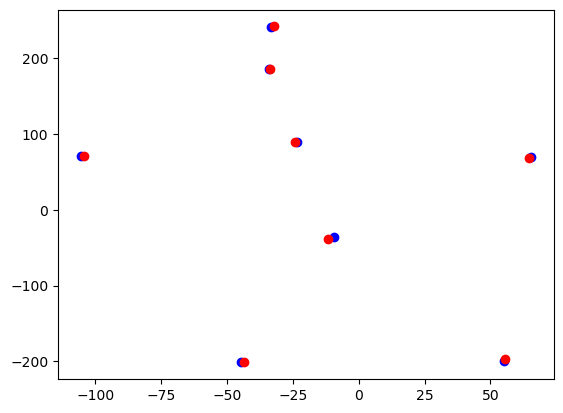

[1451.48689365 1394.17502981 1391.49255156 1423.80271973 1425.03776646
 1427.09653859 1411.94344344 1427.13149062]
[1454.16827829 1426.27689875 1410.07452351 1426.02586398 1392.91686938
 1392.42837736 1426.31555098 1423.96007162]


In [131]:
array_auto = np.asarray(array_auto).T
array_corr = np.asarray(array_corr_t).T

fig, ax1 = plt.subplots()
ax1.scatter(array_auto[0,:], array_auto[1,:], c='b')
ax1.scatter(array_corr[0,:], array_corr[1,:], c='r')
plt.show()

print(array_auto[2])
print(array_corr[2])

Autocorrection 1, Corrected 1 	 RMSE min = 2.2760, frame 7
Autocorrection 1, Corrected 2 	 RMSE min = 1.8259, frame 6
Autocorrection 1, Maximum 1 	 RMSE min = 5.8929, frame 28
Autocorrection 1, Maximum 2 	 RMSE min = 5.5553, frame 12
Autocorrection 1, Minimum 1 	 RMSE min = 35.9044, frame 14
Autocorrection 1, Minimum 2 	 RMSE min = 3.3198, frame 21
Autocorrection 2, Corrected 1 	 RMSE min = 4.2422, frame 70
Autocorrection 2, Corrected 2 	 RMSE min = 3.9464, frame 21
Autocorrection 2, Maximum 1 	 RMSE min = 6.0393, frame 26
Autocorrection 2, Maximum 2 	 RMSE min = 6.4092, frame 71
Autocorrection 2, Minimum 1 	 RMSE min = 36.1218, frame 49
Autocorrection 2, Minimum 2 	 RMSE min = 4.0664, frame 71


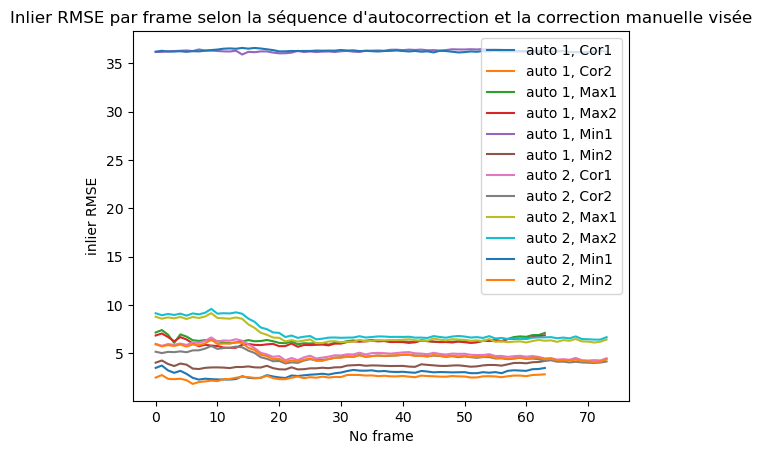

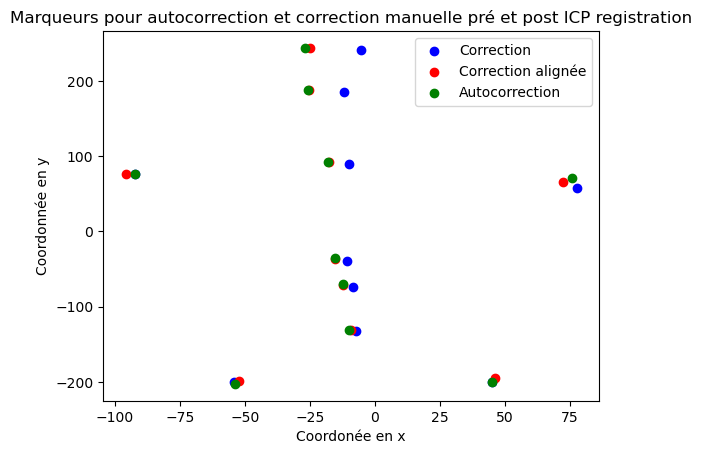

In [24]:
path = r'D:\StageE23\Data\Ete_2023\Participant19'

correction_paths = [r'Corrected\Prise01\Positions\positions_xyzr.json', r'Corrected\Prise02\Positions\positions_xyzr.json',
                    r'Maximum\Prise01\Positions\positions_xyzr.json', r'Maximum\Prise02\Positions\positions_xyzr.json',
                    r'Minimum\Prise01\Positions\positions_xyzr.json', r'Minimum\Prise02\Positions\positions_xyzr.json']

# Rassemble les dictionnaires des positions des marqueurs sur frames corrigés avec type de correction + n° prise comme clé
corrected_pos = {}
for corr_path in correction_paths:
    try:
        file_corr = open(os.path.join(path, corr_path))
        pos_corr = json.load(file_corr)
        if not str(corr_path[:-38]) in corrected_pos:
            corrected_pos.update({str(corr_path[:-38] + ' ' + corr_path[-31:-30]) : pos_corr})
    except FileNotFoundError:
        continue

# Rassemble les dictionnaires des positions des marqueurs sur autocorrection avec n° prise comme clé
auto_pos = {}
for auto_path in os.listdir(path + '/autocorrection/'):
    try:
        json_auto = open(path + '/autocorrection/' + auto_path + '/Positions/positions_xyzr.json')
        pos_auto = json.load(json_auto)
        auto_pos.update({auto_path[-1]: pos_auto})
    except FileNotFoundError:
        continue

# Compute RMSE for ICPregistration between positions of markers autocorrection and manual correction frames
# Boucle sur les séquences d'autocorrection
answer = {}
for i, pos_auto in auto_pos.items():
    # Boucle sur les frames avec correction appliquée (straight, max, min)
    for type_corr, pos_corr in corrected_pos.items():
        array_corr = [[c_corr[0], c_corr[1], c_corr[2]] for c_corr in list(pos_corr.values())[len(pos_corr.values())//2].values()] # sélection du frame central de la séquence
        array_corr = np.asarray(array_corr)
        # Boucle sur les frames d'autocorrection
        arrays_auto = []
        RMSEs = []
        for auto in pos_auto.values():
            array_auto = []
            for c_auto in auto.values():
                array_auto.append([c_auto[0], c_auto[1], c_auto[2]])

            a = sorted(array_auto, key=lambda tup: tup[0])[0]
            b = sorted(array_corr, key=lambda tup: tup[0])[0]

            dist = np.subtract(a, b)
            array_corr = array_corr + dist
            
            array_corr_t, RMSE = ICP_registration(array_corr, array_auto)
            RMSEs.append(RMSE)
        answer.update({f'Autocorrection {i}, {type_corr}': f'RMSE min = {min(RMSEs):.4f}, frame {RMSEs.index(min(RMSEs))}'})
        plt.plot(RMSEs, label=f'auto {i}, {type_corr[:3]+type_corr[-1]}')
plt.legend()
plt.title("Inlier RMSE par frame selon la séquence d'autocorrection et la correction manuelle visée")
plt.xlabel('No frame')
plt.ylabel('inlier RMSE')

plt.figure()
array_auto = np.asarray(array_auto)
plt.scatter(array_corr[:,0], array_corr[:,1], color='b', label='Correction')
plt.scatter(array_corr_t[:,0], array_corr_t[:,1], color='r', label='Correction alignée')
plt.scatter(array_auto[:,0], array_auto[:,1], color='g', label='Autocorrection')
plt.legend()
plt.title("Marqueurs pour autocorrection et correction manuelle pré et post ICP registration")
plt.xlabel('Coordonée en x')
plt.ylabel('Coordonnée en y')

for key, vals in answer.items():
    print(key, '\t', vals)



In [47]:
path = r'D:\StageE23\Data\Ete_2023\Participant19\Corrected\Prise02\Positions\positions_xyzr.json'
file_corr = open(path)
dict_corr = json.load(file_corr)
print(dict_corr)
print(list(dict_corr.values())[len(dict_corr.values())//2])
array_corr = np.asarray([[c_corr[0], c_corr[1], c_corr[2]] for c_corr in list(dict_corr.values())[len(dict_corr.values())//2].values()]) # sélection du frame central de la séquence

dict_coordo_xyz_labels_r=json.load(open(r'D:\StageE23\Data\Ete_2023\Participant19\autocorrection\Prise01\Positions\positions_xyzr.json'))
array_auto = np.asarray([[c_corr[0], c_corr[1], c_corr[2]] for c_corr in list(dict_coordo_xyz_labels_r[f'image10'].values())]) # sélection du frame central de la séquence
array_corr_t, RMSE = ICP_registration(array_corr, array_auto)
            
corr_t_sorted = sorted(array_corr_t, key=lambda tup: tup[1])
print(corr_t_sorted)
IG_ID = corr_t_sorted[:2]
print(IG_ID)
IG = np.sort(IG_ID, 0)[0]
ID = np.sort(IG_ID, 0)[1]
print(IG, ID)


{'image1': {'C7': [43.766597083521965, 249.45683381249393, 1744.1178916233443], 'Tsup': [42.25110967868442, 193.54294380089567, 1719.4232720736097], 'Tap': [49.730452773370935, 98.02700479131823, 1704.3575489844466], 'Tinf': [58.25977363528372, -29.819326511662524, 1720.9286250877228], 'Lap': [61.882911825684964, -63.37341132898928, 1723.4716072328727], 'Linf': [64.23922101007918, -122.3393436097248, 1725.5961788090967], 'ScG': [-29.172720429736742, 79.46883314175261, 1685.7801507104996], 'ScD': [138.02342345598487, 72.98845014035487, 1687.5019668009302], 'IG': [21.17410755661269, -191.782655, 1719.073516734905], 'ID': [120.17245644338729, -191.78265499999998, 1719.071383265095]}, 'image2': {'C7': [44.88366491287249, 250.58848687530042, 1745.74309763741], 'Tsup': [42.193367288958925, 193.50289961924483, 1719.0754057681925], 'Tap': [49.76948330241386, 98.04044628226569, 1704.5845397037715], 'Tinf': [58.26530345278025, -29.819858184834686, 1720.960164522009], 'Lap': [61.925418603054936, 

In [116]:
xyz = np.load(r'D:\StageE23\Data\Ete_2023\Participant19\Corrected\Prise01\xyz_images\pt19_corrected_01_131397_XYZ_0.npy')
xyz_crop = xyz[411:1324, 179:940]
print(ID)
print(xyz_crop.shape)

for c in xyz[:,:]:
    diff = abs(np.subtract(ID, c))
    if np.all(diff < 10):
        pixel = c
        print(pixel)
        break
    else:
        continue

x = (np.where(abs(xyz_crop[:,:] - IG[0]) < .001))
y = (np.where(abs(xyz_crop[:,:] - IG[1]) < .001))
z = (np.where(abs(xyz_crop[:,:] - IG[2]) < .001))


[  52.32365476 -196.55745897 1425.16501863]
(913, 761, 3)


In [122]:
x = np.array([1, 2, 4])
y = np.array([2,3,4])

diff = abs(np.subtract(x, y))
print(diff)
np.all(diff < 1)

[1 1 0]


False